# Introduction to JumpStart - Semantic Segmentation with Simple Oxford Pet Dataset

---
Welcome to Amazon [SageMaker JumpStart](https://docs.aws.amazon.com/sagemaker/latest/dg/studio-jumpstart.html)! You can use JumpStart to solve many Machine Learning tasks through one-click in SageMaker Studio, or through [SageMaker JumpStart API](https://sagemaker.readthedocs.io/en/stable/doc_utils/jumpstart.html). In this demo notebook, we demonstrate how to use the JumpStart API for Semantic Segmentation. Semantic segmentation is the task of detecting and delineating each distinct object of interest appearing in an image. It is a fine-grained, pixel-level approach to developing computer vision applications. It tags every pixel in an image with a class label from a predefined set of classes. It differs from Instance Segmentation in the following: Semantic Segmentation treats multiple objects of the same class as a single entity whereas Instance Segmentation treats multiple objects of the same class as distinct individual instances.


In this notebook, we demonstrate two use cases of semantic segmentation models: 

* How to use pre-trained Semantic Segmentation models for inference.
* How to use JumpStart transfer learning algorithm to finetune a Semantic Segmentation model on a custom dataset.

Note: This notebook was tested on Amazon SageMaker Notebook instance with `conda_pytorch_p38` Kernel.

---

1. [Set Up](#1.-Set-Up)
2. [Select a pre-trained model](#2.-Select-a-pre-trained-model)
3. [Run inference on the pre-trained model](#3.-Run-inference-on-the-pre-trained-model)
    * [Retrieve JumpStart Artifacts & Deploy an Endpoint](#3.1.-Retrieve-JumpStart-Artifacts-&-Deploy-an-Endpoint)
    * [Download an example image for inference](#3.2.-Download-an-example-image-for-inference)
    * [Query endpoint and parse response](#3.3.-Query-endpoint-and-parse-response)
    * [Display model predictions](#3.4.-Display-model-predictions)
    * [Clean up the endpoint](#3.5.-Clean-up-the-endpoint)
4. [Fine-tune the pre-trained model on a custom dataset](#4.-Fine-tune-the-pre-trained-model-on-a-custom-dataset)
    * [Retrieve Training Artifacts](#4.1.-Retrieve-Training-Artifacts)
    * [Set Training parameters](#4.2.-Set-Training-parameters)
    * [Train with Automatic Model Tuning (HPO)](#AMT)
    * [Start Training](#4.4.-Start-Training)
    * [Deploy and run inference on the fine-tuned model](#4.5.-Deploy-and-run-inference-on-the-fine-tuned-model)


## 1. Set Up

---
Before executing the notebook, there are some initial steps required for set up. This notebook requires latest version of sagemaker and ipywidgets

---

In [1]:
!pip install sagemaker ipywidgets --upgrade --quiet

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
awscli 1.27.22 requires botocore==1.29.22, but you have botocore 1.29.41 which is incompatible.
aiobotocore 2.0.1 requires botocore<1.22.9,>=1.22.8, but you have botocore 1.29.41 which is incompatible.
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/pytorch_p38/bin/python -m pip install --upgrade pip' command.


In [2]:
!pip install segmentation-models-pytorch --quiet

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/pytorch_p38/bin/python -m pip install --upgrade pip' command.


## Dataset

In this example we will use predefined `Dataset` class for simplicity. The dataset actually read pairs of images and masks from disk and return `sample` - dictionary with keys `image`, `mask` and others (not relevant for this example).

⚠️ **Dataset preparation checklist** ⚠️

In case you writing your own dataset, please, make sure that:

1.   **Images** 🖼  
    ✅   Images from dataset have **the same size**, required for packing images to a batch.  
    ✅   Images height and width are **divisible by 32**. This step is important for segmentation, because almost all models have skip-connections between encoder and decoder and all encoders have 5 downsampling stages (2 ^ 5 = 32). Very likely you will face with error when model will try to concatenate encoder and decoder features if height or width is not divisible by 32.  
    ✅   Images have **correct axes order**. PyTorch works with CHW order, we read images in HWC [height, width, channels], don`t forget to transpose image.
2.   **Masks** 🔳  
    ✅   Masks have **the same sizes** as images.   
    ✅   Masks have only `0` - background and `1` - target class values (for binary segmentation).  
    ✅   Even if mask don`t have channels, you need it. Convert each mask from **HW to 1HW** format for binary segmentation (expand the first dimension).

Some of these checks are included in LightningModule below during the training.

❗️ And the main rule: your train, validation and test sets are not intersects with each other!

In [3]:
import os
from segmentation_models_pytorch.datasets import SimpleOxfordPetDataset

In [4]:
# download data
root = "./simple-oxford-pet-dataset/"
SimpleOxfordPetDataset.download(root)

images.tar.gz: 100%|██████████| 755M/755M [00:23<00:00, 33.3MB/s]    
annotations.tar.gz: 100%|██████████| 18.3M/18.3M [00:02<00:00, 9.06MB/s]


In [5]:
!ls ./simple-oxford-pet-dataset/

annotations  annotations.tar.gz  images  images.tar.gz


In [6]:
!mv ./simple-oxford-pet-dataset/annotations/trimaps/ ./simple-oxford-pet-dataset/masks

In [7]:
!cd ./simple-oxford-pet-dataset/;rm -rf annotations.tar.gz images.tar.gz annotations

In [8]:
!ls ./simple-oxford-pet-dataset/

images	masks


In [9]:
!cd ./simple-oxford-pet-dataset/masks/;ls -rtla |wc

  14783  133040 1066367


In [10]:
!cd ./simple-oxford-pet-dataset/masks/;ls -rtla *png |wc

   7390   66510  518344


Let's delete all files starting with `._`

In [11]:
!cd ./simple-oxford-pet-dataset/masks/;rm ._*

In [12]:
!cd ./simple-oxford-pet-dataset/masks/;ls -rtla *png |wc

   7390   66510  518344


In [13]:
!cd ./simple-oxford-pet-dataset/images/;rm *.mat

### Permissions and environment variables

---
To train and host on Amazon SageMaker, we need to set up and authenticate the use of AWS services. Here, we use the execution role associated with the current notebook as the AWS account role with SageMaker access. It has necessary permissions, including access to your data in S3. 

---

In [15]:
import sagemaker, boto3, json
from sagemaker import get_execution_role

aws_role = get_execution_role()
aws_region = boto3.Session().region_name
sess = sagemaker.Session()
bucket = sess.default_bucket()  # this could also be a hard-coded bucket name

prefix="jumpstart-semantic-segmentation/simple-oxford-pet-dataset"

print("Using bucket " + bucket)
print("Using prefix " + prefix)

Using bucket sagemaker-us-east-1-062083580489
Using prefix jumpstart-semantic-segmentation/simple-oxford-pet-dataset


## Upload training data to S3

This will take around 15 minutes. 

In [16]:
training_dataset_s3_path = f"s3://{bucket}/{prefix}"
training_dataset_s3_path

's3://sagemaker-us-east-1-062083580489/jumpstart-semantic-segmentation/simple-oxford-pet-dataset'

In [17]:
%%writefile ./simple-oxford-pet-dataset/class_label_to_prediction_index.json
{"0": 0, "1": 1, "2": 2, "3": 3, "4": 4, "5": 5, "6": 6, "7": 7}

Writing ./simple-oxford-pet-dataset/class_label_to_prediction_index.json


In [18]:
!aws s3 cp ./simple-oxford-pet-dataset/class_label_to_prediction_index.json {training_dataset_s3_path}/

upload: simple-oxford-pet-dataset/class_label_to_prediction_index.json to s3://sagemaker-us-east-1-062083580489/jumpstart-semantic-segmentation/simple-oxford-pet-dataset/class_label_to_prediction_index.json


In [19]:
!aws s3 cp ./simple-oxford-pet-dataset/images/ {training_dataset_s3_path}/images/ --recursive

upload: simple-oxford-pet-dataset/images/Abyssinian_1.jpg to s3://sagemaker-us-east-1-062083580489/jumpstart-semantic-segmentation/simple-oxford-pet-dataset/images/Abyssinian_1.jpg
upload: simple-oxford-pet-dataset/images/Abyssinian_101.jpg to s3://sagemaker-us-east-1-062083580489/jumpstart-semantic-segmentation/simple-oxford-pet-dataset/images/Abyssinian_101.jpg
upload: simple-oxford-pet-dataset/images/Abyssinian_10.jpg to s3://sagemaker-us-east-1-062083580489/jumpstart-semantic-segmentation/simple-oxford-pet-dataset/images/Abyssinian_10.jpg
upload: simple-oxford-pet-dataset/images/Abyssinian_103.jpg to s3://sagemaker-us-east-1-062083580489/jumpstart-semantic-segmentation/simple-oxford-pet-dataset/images/Abyssinian_103.jpg
upload: simple-oxford-pet-dataset/images/Abyssinian_104.jpg to s3://sagemaker-us-east-1-062083580489/jumpstart-semantic-segmentation/simple-oxford-pet-dataset/images/Abyssinian_104.jpg
upload: simple-oxford-pet-dataset/images/Abyssinian_108.jpg to s3://sagemaker-us-

In [20]:
!aws s3 cp ./simple-oxford-pet-dataset/masks/ {training_dataset_s3_path}/masks/ --recursive

upload: simple-oxford-pet-dataset/masks/Abyssinian_100.png to s3://sagemaker-us-east-1-062083580489/jumpstart-semantic-segmentation/simple-oxford-pet-dataset/masks/Abyssinian_100.png
upload: simple-oxford-pet-dataset/masks/Abyssinian_102.png to s3://sagemaker-us-east-1-062083580489/jumpstart-semantic-segmentation/simple-oxford-pet-dataset/masks/Abyssinian_102.png
upload: simple-oxford-pet-dataset/masks/Abyssinian_105.png to s3://sagemaker-us-east-1-062083580489/jumpstart-semantic-segmentation/simple-oxford-pet-dataset/masks/Abyssinian_105.png
upload: simple-oxford-pet-dataset/masks/Abyssinian_108.png to s3://sagemaker-us-east-1-062083580489/jumpstart-semantic-segmentation/simple-oxford-pet-dataset/masks/Abyssinian_108.png
upload: simple-oxford-pet-dataset/masks/Abyssinian_107.png to s3://sagemaker-us-east-1-062083580489/jumpstart-semantic-segmentation/simple-oxford-pet-dataset/masks/Abyssinian_107.png
upload: simple-oxford-pet-dataset/masks/Abyssinian_10.png to s3://sagemaker-us-east-1

In [21]:
!aws s3 ls {training_dataset_s3_path}/

                           PRE images/
                           PRE masks/
2023-01-03 09:02:24         65 class_label_to_prediction_index.json


In [22]:
!aws s3 ls {training_dataset_s3_path}/images/ | wc

   7390   29560  377934


In [23]:
!aws s3 ls {training_dataset_s3_path}/masks/ | wc

   7390   29560  377934


### 2. Select a pre-trained model

***
Here, we download jumpstart model_manifest file from the jumpstart s3 bucket, filter-out all the Semantic Segmentation models and select a model for inference.
***

In [26]:
from ipywidgets import Dropdown

# download JumpStart model_manifest file.
boto3.client("s3").download_file(
    f"jumpstart-cache-prod-{aws_region}", "models_manifest.json", "models_manifest.json"
)
with open("models_manifest.json", "rb") as json_file:
    model_list = json.load(json_file)

# filter-out all the Semantic Segmentation models from the manifest list.
semseg_models = []
for model in model_list:
    model_id = model["model_id"]
    if "-semseg-" in model_id and model_id not in semseg_models:
        semseg_models.append(model_id)

print(f"\033[38;5;2mChose a model: \033[0;0m\n")

# display the model-ids in a dropdown to select a model for inference.
model_dropdown = Dropdown(
    options=semseg_models,
    value="mxnet-semseg-fcn-resnet50-ade",
    description="",
    style={"description_width": "initial"},
    layout={"width": "max-content"},
)
display(model_dropdown)

Chose a model: 



Dropdown(index=3, layout=Layout(width='max-content'), options=('mxnet-semseg-fcn-resnet101-ade', 'mxnet-semseg…

In [27]:
# model_version="*" fetches the latest version of the model
model_id, model_version = model_dropdown.value, "*"

[Semantic Segmentation](https://github.com/dmlc/gluon-cv/tree/master/scripts/segmentation)

`fcn_resnet101_voc` model seems to be the best.

In [28]:
model_id, model_version

('mxnet-semseg-fcn-resnet101-voc', '*')

## 3. Run inference on the pre-trained model

***

Using JumpStart, we can perform inference on the pre-trained model, even without fine-tuning it first on a new dataset. 
***

### 3.1. Retrieve JumpStart Artifacts & Deploy an Endpoint

***
We retrieve the `deploy_image_uri`, `deploy_source_uri`, and `base_model_uri` for the pre-trained model. To host the pre-trained base-model, we create an instance of [`sagemaker.model.Model`](https://sagemaker.readthedocs.io/en/stable/api/inference/model.html) and deploy it.
***

In [29]:
from sagemaker import image_uris, model_uris, script_uris, hyperparameters
from sagemaker.model import Model
from sagemaker.predictor import Predictor
from sagemaker.utils import name_from_base


endpoint_name = name_from_base(f"jumpstart-example-infer-{model_id}")

inference_instance_type = "ml.p2.xlarge"

# Retrieve the inference docker container uri
deploy_image_uri = image_uris.retrieve(
    region=None,
    framework=None,  # automatically inferred from model_id
    image_scope="inference",
    model_id=model_id,
    model_version=model_version,
    instance_type=inference_instance_type,
)

# Retrieve the inference script uri. This includes scripts for model loading, inference handling etc.
deploy_source_uri = script_uris.retrieve(
    model_id=model_id, model_version=model_version, script_scope="inference"
)


# Retrieve the base model uri
base_model_uri = model_uris.retrieve(
    model_id=model_id, model_version=model_version, model_scope="inference"
)


# Create the SageMaker model instance
model = Model(
    image_uri=deploy_image_uri,
    source_dir=deploy_source_uri,
    model_data=base_model_uri,
    entry_point="inference.py",  # entry point file in source_dir and present in deploy_source_uri
    role=aws_role,
    predictor_cls=Predictor,
    name=endpoint_name,
)

# deploy the Model. Note that we need to pass Predictor class when we deploy model through Model class,
# for being able to run inference through the sagemaker API.
base_model_predictor = model.deploy(
    initial_instance_count=1,
    instance_type=inference_instance_type,
    predictor_cls=Predictor,
    endpoint_name=endpoint_name,
)

---------!

### 3.3. Query endpoint and parse response

---
Input to the endpoint is a single image in binary format. Response of the endpoint is a predicted label for each pixel in the image. 

---

In [33]:
import json


def query(model_predictor, image_file_name):
    """Query the model predictor."""

    with open(image_file_name, "rb") as file:
        input_img_rb = file.read()

    query_response = model_predictor.predict(
        input_img_rb,
        {
            "ContentType": "application/x-image",
            "Accept": "application/json;verbose",
        },
    )
    return query_response


def parse_response(query_response):
    """Parse response and return predictions as well as the set of all labels and object labels present in the image."""
    response_dict = json.loads(query_response)
    return response_dict["predictions"], response_dict["labels"], response_dict["image_labels"]

In [37]:
image_1 = "./simple-oxford-pet-dataset/images/Abyssinian_1.jpg"

In [38]:
query_response = query(base_model_predictor, image_1)

predictions, labels, image_labels = parse_response(query_response)
print("Objects present in the picture:", image_labels)

Objects present in the picture: ['background', 'cat', 'chair', 'dog', 'sofa']


### 3.4. Display model predictions
---
Next, we display the bounding boxes overlaid on the original image. To get color palette for visualization, we borrow the VOC palette implementation from [GluonCV](https://cv.gluon.ai/_modules/gluoncv/utils/viz/segmentation.html#get_color_pallete)  

---

In [39]:
import matplotlib.image as mpimg
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image


def getvocpalette(num_cls):
    """Get a color palette."""

    n = num_cls
    palette = [0] * (n * 3)
    for j in range(0, n):
        lab = j
        palette[j * 3 + 0] = 0
        palette[j * 3 + 1] = 0
        palette[j * 3 + 2] = 0
        i = 0
        while lab > 0:
            palette[j * 3 + 0] |= ((lab >> 0) & 1) << (7 - i)
            palette[j * 3 + 1] |= ((lab >> 1) & 1) << (7 - i)
            palette[j * 3 + 2] |= ((lab >> 2) & 1) << (7 - i)
            i = i + 1
            lab >>= 3
    return palette


def display_predictions(predictions):
    """Display predictions with each pixel subsituted by the color of the corresponding label."""

    palette = getvocpalette(256)
    npimg = np.array(predictions)
    npimg[npimg == -1] = 255
    mask = Image.fromarray(npimg.astype("uint8"))

    mask.putpalette(palette)
    plt.imshow(mask)

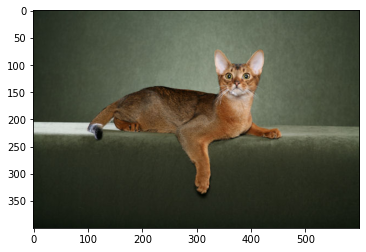

In [40]:
plt.imshow(mpimg.imread(image_1))

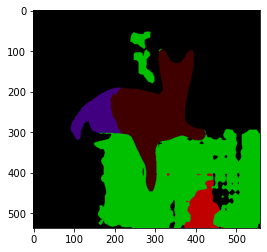

In [41]:
display_predictions(predictions)

### 3.5. Clean up the endpoint

In [42]:
# Delete the SageMaker endpoint
base_model_predictor.delete_model()
base_model_predictor.delete_endpoint()

## 4. Fine-tune the pre-trained model on a custom dataset

---
Previously, we saw how to run inference on a pre-trained model. Next, we discuss how a model can be finetuned to a custom dataset with any number of classes. 

The model available for fine-tuning build a fully convolutional network (FCN) "head" on top of the base network. The fine-tuning step fine-tunes the FCNHead while keeping the parameters of the rest of the model frozen, and returns the fine-tuned model. The objective is to minimize per-pixel Softmax Cross Entropy Loss to train FCN. The model returned by fine-tuning can be further deployed for inference. Below are the instructions for how the training data should be formatted for input to the model.

* Input: A directory with sub-directories images, masks and a file class_label_to_prediction_index.json.

* Output: A trained model that can be deployed for inference.
    * A label mapping file is saved along with the trained model file on the s3 bucket.

The input directory should look like below if the training data contains two images. The names of .png files can be anything.


* input_directory
    * images
        * abc.png
        * def.png
    * masks
        * abc.png
        * def.png
    * class_label_to_prediction_index.json

The mask files should have class label information for each pixel.


We provide pennfudanped dataset as a default dataset for fine-tuning the model.
PennFudanPed comprises images of pedestrians. The dataset has been downloaded from [here](https://www.cis.upenn.edu/~jshi/ped_html/#pub1). 

Citation:
<sub><sup>
@ONLINE {pennfudanped,
author = "Liming Wang1, Jianbo Shi2, Gang Song2, and I-fan Shen1",
title = "Penn-Fudan Database for Pedestrian Detection and Segmentation",
year = "2007",
url = "https://www.cis.upenn.edu/~jshi/ped_html/" }
</sup></sub>

### 4.1. Retrieve Training Artifacts

Here, we retrieve the training docker container, the training algorithm source, and the pre-trained base model. Note that model_version="*" fetches the latest model.

---

In [43]:
from sagemaker import image_uris, model_uris, script_uris

train_scope = "training"
training_instance_type = "ml.p3.2xlarge"

# Retrieve the docker image
train_image_uri = image_uris.retrieve(
    region=None,
    framework=None,  # automatically inferred from model_id
    model_id=model_id,
    model_version=model_version,
    image_scope=train_scope,
    instance_type=training_instance_type,
)

# Retrieve the training script. This contains all the necessary files including data processing, model training etc.
train_source_uri = script_uris.retrieve(
    model_id=model_id, model_version=model_version, script_scope=train_scope
)
# Retrieve the pre-trained model tarball to further fine-tune
train_model_uri = model_uris.retrieve(
    model_id=model_id, model_version=model_version, model_scope=train_scope
)

print(train_image_uri)
print(train_source_uri)
print(train_model_uri)

763104351884.dkr.ecr.us-east-1.amazonaws.com/mxnet-training:1.9.0-gpu-py38
s3://jumpstart-cache-prod-us-east-1/source-directory-tarballs/mxnet/transfer_learning/semseg/v1.4.1/sourcedir.tar.gz
s3://jumpstart-cache-prod-us-east-1/mxnet-training/train-mxnet-semseg-fcn-resnet101-voc.tar.gz


### 4.2. Set Training parameters

---
Now that we are done with all the set up that is needed, we are ready to train our Semantic Segmentation model. To begin, let us create a [``sageMaker.estimator.Estimator``](https://sagemaker.readthedocs.io/en/stable/api/training/estimators.html) object. This estimator will launch the training job. 

There are two kinds of parameters that need to be set for training. The first one are the parameters for the training job. These include: (i) Training data path. This is S3 folder in which the input data is stored, (ii) Output path: This the s3 folder in which the training output is stored. (iii) Training instance type: This indicates the type of machine on which to run the training. Typically, we use GPU instances for these training. We defined the training instance type above to fetch the correct train_image_uri. 

The second set of parameters are algorithm specific training hyper-parameters. 

---

In [44]:
print(training_dataset_s3_path)

output_bucket = sess.default_bucket()
output_prefix = "jumpstart-example-semseg-training"

s3_output_location = f"s3://{output_bucket}/{output_prefix}/output"

s3://sagemaker-us-east-1-062083580489/jumpstart-semantic-segmentation/simple-oxford-pet-dataset


---
For algorithm specific hyper-parameters, we start by fetching python dictionary of the training hyper-parameters that the algorithm accepts with their default values. This can then be overridden to custom values.

---

In [46]:
from sagemaker import hyperparameters

# Retrieve the default hyper-parameters for fine-tuning the model
hyperparameters = hyperparameters.retrieve_default(model_id=model_id, model_version=model_version)

# [Optional] Override default hyperparameters with custom values
hyperparameters["epochs"] = "4"
print(hyperparameters)

{'epochs': '4', 'adam-learning-rate': '0.001', 'batch-size': '2', 'train-only-top-layer': 'True'}


### 4.3. Train with Automatic Model Tuning ([HPO](https://docs.aws.amazon.com/sagemaker/latest/dg/automatic-model-tuning.html)) <a id='AMT'></a>
***
Amazon SageMaker automatic model tuning, also known as hyperparameter tuning, finds the best version of a model by running many training jobs on your dataset using the algorithm and ranges of hyperparameters that you specify. It then chooses the hyperparameter values that result in a model that performs the best, as measured by a metric that you choose. We will use a [HyperparameterTuner](https://sagemaker.readthedocs.io/en/stable/api/training/tuner.html) object to interact with Amazon SageMaker hyperparameter tuning APIs.
***

In [47]:
from sagemaker.tuner import ContinuousParameter

# Use AMT for tuning and selecting the best model
use_amt = False

# Define objective metric per framework, based on which the best model will be selected.
metric_definitions_per_model = {
    "mxnet": {
        "metrics": [{"Name": "val_loss", "Regex": "validation loss=([0-9\\.]+)"}],
        "type": "Minimize",
    }
}

# You can select from the hyperparameters supported by the model, and configure ranges of values to be searched for training the optimal model.(https://docs.aws.amazon.com/sagemaker/latest/dg/automatic-model-tuning-define-ranges.html)
hyperparameter_ranges = {
    "adam-learning-rate": ContinuousParameter(0.0001, 0.1, scaling_type="Logarithmic")
}

# Increase the total number of training jobs run by AMT, for increased accuracy (and training time).
max_jobs = 6
# Change parallel training jobs run by AMT to reduce total training time, constrained by your account limits.
# if max_jobs=max_parallel_jobs then Bayesian search turns to Random.
max_parallel_jobs = 2

### 4.4. Start Training

---
We start by creating the estimator object with all the required assets and then launch the training job.  It takes around an hour on the default dataset.

---

In [ ]:
from sagemaker.estimator import Estimator
from sagemaker.utils import name_from_base
from sagemaker.tuner import HyperparameterTuner

training_job_name = name_from_base(f"jumpstart-example-{model_id}-transfer-learning")

# Create SageMaker Estimator instance
semseg_estimator = Estimator(
    role=aws_role,
    image_uri=train_image_uri,
    source_dir=train_source_uri,
    model_uri=train_model_uri,
    entry_point="transfer_learning.py",  # Entry-point file in source_dir and present in train_source_uri.
    instance_count=1,
    instance_type=training_instance_type,
    max_run=360000,
    hyperparameters=hyperparameters,
    output_path=s3_output_location,
    base_job_name=training_job_name,
)

if use_amt:
    metric_definitions = next(
        value for key, value in metric_definitions_per_model.items() if model_id.startswith(key)
    )

    hp_tuner = HyperparameterTuner(
        semseg_estimator,
        metric_definitions["metrics"][0]["Name"],
        hyperparameter_ranges,
        metric_definitions["metrics"],
        max_jobs=max_jobs,
        max_parallel_jobs=max_parallel_jobs,
        objective_type=metric_definitions["type"],
        base_tuning_job_name=training_job_name,
    )

    # Launch a SageMaker Tuning job to search for the best hyperparameters
    hp_tuner.fit({"training": training_dataset_s3_path})
else:
    # Launch a SageMaker Training job by passing s3 path of the training data
    semseg_estimator.fit({"training": training_dataset_s3_path}, logs=True)

INFO:sagemaker:Creating training-job with name: jumpstart-example-mxnet-semseg-fcn-resn-2023-01-03-09-14-51-245


2023-01-03 09:14:51 Starting - Starting the training job...
2023-01-03 09:15:18 Starting - Preparing the instances for training.........
2023-01-03 09:16:30 Downloading - Downloading input data...
2023-01-03 09:17:15 Training - Downloading the training image...............
2023-01-03 09:19:36 Training - Training image download completed. Training in progress...2023-01-03 09:19:56,866 sagemaker-training-toolkit INFO     Imported framework sagemaker_mxnet_container.training
2023-01-03 09:19:56,883 sagemaker-training-toolkit INFO     No Neurons detected (normal if no neurons installed)
2023-01-03 09:19:56,897 sagemaker_mxnet_container.training INFO     MXNet training environment: {'SM_HOSTS': '["algo-1"]', 'SM_NETWORK_INTERFACE_NAME': 'eth0', 'SM_HPS': '{"adam-learning-rate":"0.001","batch-size":"2","epochs":"4","train-only-top-layer":"True"}', 'SM_USER_ENTRY_POINT': 'transfer_learning.py', 'SM_FRAMEWORK_PARAMS': '{}', 'SM_RESOURCE_CONFIG': '{"current_group_name":"homogeneousCluster","cur

### 4.5. Deploy and run inference on the fine-tuned model

---

A trained model does nothing on its own. We now want to use the model to perform inference. We follow the same steps as in [3. Run inference on the pre-trained model](#3.-Run-inference-on-the-pre-trained-model). We start by retrieving the jumpstart artifacts for deploying an endpoint. However, instead of base_predictor, we  deploy the `semseg_estimator` that we fine-tuned.

---

In [49]:
inference_instance_type = "ml.p2.xlarge"

# Retrieve the inference docker container uri
deploy_image_uri = image_uris.retrieve(
    region=None,
    framework=None,  # automatically inferred from model_id
    image_scope="inference",
    model_id=model_id,
    model_version=model_version,
    instance_type=inference_instance_type,
)
# Retrieve the inference script uri. This includes scripts for model loading, inference handling etc.
deploy_source_uri = script_uris.retrieve(
    model_id=model_id, model_version=model_version, script_scope="inference"
)

endpoint_name = name_from_base(f"jumpstart-example-FT-{model_id}-")

# Use the estimator from the previous step to deploy to a SageMaker endpoint
finetuned_predictor = (hp_tuner if use_amt else semseg_estimator).deploy(
    initial_instance_count=1,
    instance_type=inference_instance_type,
    entry_point="inference.py",  # entry point file in source_dir and present in deploy_source_uri
    image_uri=deploy_image_uri,
    source_dir=deploy_source_uri,
    endpoint_name=endpoint_name,
)

INFO:sagemaker:Creating model with name: sagemaker-jumpstart-2023-01-03-11-15-03-883
INFO:sagemaker:Creating endpoint-config with name jumpstart-example-FT-mxnet-semseg-fcn-r-2023-01-03-11-15-03-883
INFO:sagemaker:Creating endpoint with name jumpstart-example-FT-mxnet-semseg-fcn-r-2023-01-03-11-15-03-883


---------!

---
Next, we query the finetuned model, parse the response and display the predictions. Functions for these are implemented in sections [3.3. Query endpoint and parse response](#3.3.-Query-endpoint-and-parse-response) and [3.4. Display model predictions](#3.4.-Display-model-predictions)

---

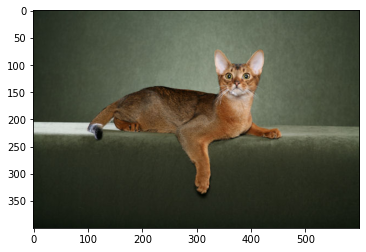

In [51]:
plt.imshow(mpimg.imread(image_1))

In [53]:
query_response = query(finetuned_predictor, image_1)
predictions, labels, image_labels = parse_response(query_response)
print("Objects present in the picture:", image_labels)

Objects present in the picture: ['1', '2', '3']


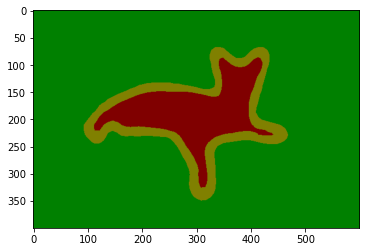

In [54]:
display_predictions(predictions)

---
Next, we delete the endpoint corresponding to the finetuned model.

---

In [55]:
# Delete the SageMaker endpoint
finetuned_predictor.delete_model()
finetuned_predictor.delete_endpoint()

INFO:sagemaker:Deleting model with name: sagemaker-jumpstart-2023-01-03-11-15-03-883
INFO:sagemaker:Deleting endpoint configuration with name: jumpstart-example-FT-mxnet-semseg-fcn-r-2023-01-03-11-15-03-883
INFO:sagemaker:Deleting endpoint with name: jumpstart-example-FT-mxnet-semseg-fcn-r-2023-01-03-11-15-03-883
